# Guided Data Challenge Part I: Introduction to Differentiable Programming in Jax

Author:
 - [@EiffL](https://github.com/EiffL) (Fancois Lanusse)
 

## Overview 

The overall aim of this challenge is to solve image inverse problem (denoising, deconvolution, inpainting) in a fully Bayesian way i.e. drawing from a posterior distribution, and using a deep generative model as a prior. 

More concretely, we will consider a deconvolution problem where one aims to recover a high quality image from a low resolution image degraded by an instrumental response. The following figure provides an illustration of the problem:

![](https://www.researchgate.net/profile/Alan-Heavens/publication/1910339/figure/fig1/AS:394636699947010@1471100129570/Illustration-of-the-forward-problem-The-upper-panels-show-how-the-original-galaxy-image.png)

What we will have access to is an observed galaxy on the right of the chain, and we will try to recover the high resolution image before PSF convolution.


We will use two datasets as the basis for this challenge:
- Galaxies from the Hubble Space Telescope COSMOS survey, described for instance [here](https://arxiv.org/pdf/1308.4982.pdf#page=24) under `REAL GALAXY DATASET`.
- Galaxies of the [HSC Survey](https://hsc-release.mtk.nao.ac.jp/doc/), taken with the ground-based Subaru telescope

This guided data challenge will be split into 3 parts. In this first part, we will be discovering the tools and datasets.


### Learning objectives

The goal of this first part of this guided data challenge is to get familiar with the datasets, and more importantly with the tools needed for the next steps. You will put into practice the following:

  - Build a forward model using Jax
  - Build a likelihood using TensorFlow Probability
  - Retrieve maximum likelihood solution by optimization
  - (Stretch goal): Learn to write a Neural Network with DeepMind's Haiku
  

## Before we begin... A few words about JAX

What's the best Deep Learning framework? TensorFlow? PyTorch? Wrong: all you ever want is JAX :-)

![](https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png)

JAX = NumPy + autograd + XLA

In other words, it looks like pure NumPy, but is automatically differentiable, and runs on XLA (i.e. GPU accelerated). Checkout the [full documentation](https://jax.readthedocs.io/en/latest/index.html) to discover the many awesome features JAX has to offer.

#### Autodiff

For our purposes, the most interesting feature of JAX will be automatic differentiation, which is performed using `jax.grad`

In [1]:
%pylab inline
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Let's build a function of x that returns a scalar
def f(x):
    y = 2*x+1
    return y

In [3]:
# To get the derivative of this function, I simply use jax.grad
df_dx = jax.grad(f)

In [4]:
df_dx

<function __main__.f(x)>

`jax.grad` has *transformed* my function `f` into a new function that comptutes its gradient.

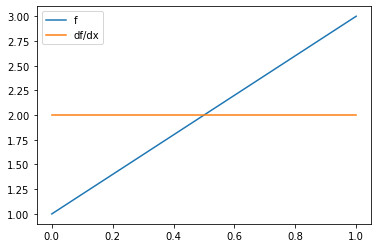

In [5]:
u = jnp.linspace(0,1)
plot(u, f(u), label='f')
plot(u,jax.vmap(df_dx)(u), label='df/dx')
legend()

#### Vectorization with `vmap`

Another awesome feature of JAX is the ability to batch any function using the `jax.vmap` transformation. Say you have a function that works on a single example:

In [6]:
def f(x):
    # Expect x to be of shape [16, 16]
    nx, ny = x.shape 
    x = x + jnp.ones([nx,ny])
    return x

In [7]:
x = jnp.zeros([16,16])
f(x).shape

(16, 16)

In [8]:
# But this function wouldn't work if I had a batch of images
x = jnp.zeros([1,16,16])
f(x).shape # THIS SHOULD FAIL

ValueError: too many values to unpack (expected 2)

In [9]:
# But I can use jax magic
f_batched = jax.vmap(f)

x = jnp.zeros([1,16,16])
f_batched(x).shape

(1, 16, 16)

Tada! 

#### JIT compilation

The final super useful thing to know about JAX is that you can JIT (Just In Time) compile any function, they will be compiled as an XLA graph and completely bypass Python to run directly under XLA.

In [11]:
def f(x, A):
    return A.dot(x)

f_jitted = jax.jit(f)

In [12]:
x = randn(128)
A = randn(128,128)

In [13]:
f_jitted(x,A);

On this example, jitting won't make much of a difference because it is  a tiny function, but we will see later that we can JIT the computation of the loss and update of a full neural network, which then becomes lightning fast.

## Step I: Loading the data

In this section, we load the datasets for our space-based and ground-based images. Both datasets are conviently accessible as [TensorFlow Datasets](https://www.tensorflow.org/datasets) datasets, you simply need the following imports to access them:

In [14]:
import quarks2cosmos.datasets
import tensorflow_datasets as tfds

#### COSMOS Dataset

The COSMOS dataset is built from the GalSim COSMOS sample (see [here](https://galsim-developers.github.io/GalSim/_build/html/real_gal.html) for details), it contains postage stamps of real galaxies,  **convolved with an isotropized HST PSF** which is the same for all galaxies. These images are thus completely standardized, and the PSF doesn't vary from one object to the other.

Properties of COSMOS stamps:
- TRAIN and TEST splits with 40000 and 10000 images respectively
- Constant isotropic PSF
- Pixel scale 0.03
- Postage stamp size: 101x101

In [92]:
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN) # Load the TRAIN split
dset_cosmos = dset_cosmos.as_numpy_iterator()                  # Convert the dataset to numpy iterator

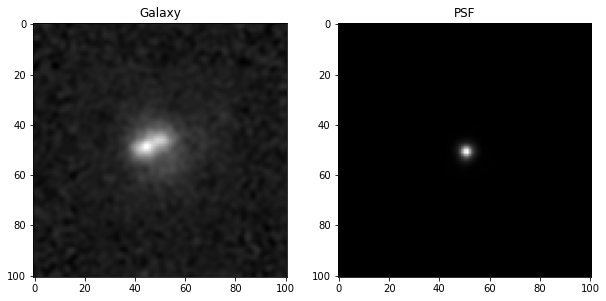

In [93]:
# Extract a new example from the dataset
cosmos = next(dset_cosmos)

figure(figsize=[10,5])
subplot(121)
imshow(cosmos['image'],cmap='gray')
title('Galaxy')
subplot(122)
imshow(cosmos['psf'],cmap='gray')
title('PSF');

#### HSC Dataset

The HSC galaxies are drawn from the PDR2 data release and extracted using the excellent [unagi](https://github.com/dr-guangtou/unagi) tool. Details of how these objects are selected can be found in this accompanying [notebook](HSCDataPreparation.ipynb), but essentially these are i-band stamps of galaxies with imag $\in [21, 23.5]$, also verifying the `forced.i_pixelflags_interpolatedcenter` condition, meaning they contain a number of interpolated pixels which intersect the center of the object. The stamps are at resolution 0.168 arcsec, and the PSF is provided for each galaxy.

Properties of HSC stamps:
- Single TRAIN split of ~10000 examples
- PSF, pixel masks, and variance map provided for every image
- Pixel scale: 0.168
- Postage stamp size: 41x41

In [94]:
dset_hsc = tfds.load("HSC", split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.as_numpy_iterator()

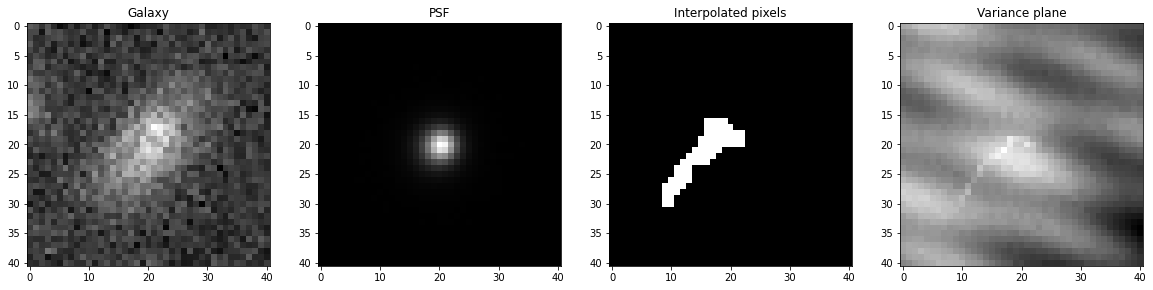

In [95]:
# Extract a new example from the dataset
hsc = next(dset_hsc)

figure(figsize=[20,5])
subplot(141)
imshow(hsc['image'],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'],cmap='gray')
title('Variance plane');

## Step II: Building a forward model



We only provides the fundamentals here, and we encourage the interested reader to directly reach out to challenge organizers to learn more :-)

The problems we will be addressing in this challenge can be written as the following:

$$y = \Pi \ast \left(  \mathbf{P} \ (\Pi_{HST}^{-1} \ast x ) \right) + n \qquad \mbox{with} \qquad n \sim \mathcal{N}(0, \sigma^2)$$ 
where $y$ are the measurements and where:
- $x$ would be a space-based HST galaxy image we would like to recover
- $\Pi_{HST}$ is the HST PSF
- $\mathbf{P}$ is a resampling operator to go from the pixel scale of HST to that of HSC images
- $\Pi$ is a given HSC PSF
- $\sigma$ is the noise variance of HSC observations.  

Typically, one would use the [GalSim software](https://github.com/GalSim-developers/GalSim) to perform these manipulations (convolution/deconvolution/resampling) but GalSim is not differentiable :-( 

For the purpose of this data challenge we provide JAX equivalent functions as part of the `quarks2cosmos.galjax` and this will allow us to write a differentiable forward model:

In [96]:
from quarks2cosmos import galjax as gj

In [97]:
def simulate_hsc(x, in_psf, out_psf):
    """ This function will simulate an image at HSC resolution given an image at HST resolution,
    accounting for input PSF and convolving by output PSF
    Args:
        x: HST resolution image (MUST BE ODD SIZE!!!!)
        in_psf: HST PSF
        out_psf: HSC PSF
    Returns:
        y: HSC simulated image of size [41,41]
    """
    y = gj.deconvolve(x, in_psf)         # Deconvolve by input PSF
    y = gj.kresample(y, 0.03, 0.168, 41) # Resample image to HSC grid
    y = gj.convolve(y,  out_psf)         # Reconvolve by HSC PSF
    return 2.587*y                       # Conversion factor for the flux

In [98]:
# Let's apply it to our input images
im = simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf'])

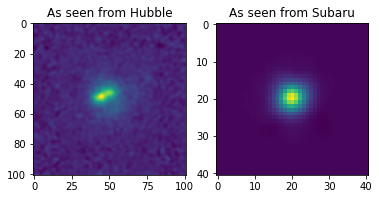

In [99]:
subplot(121)
imshow(cosmos['image'])
title('As seen from Hubble')
subplot(122)
imshow(im)
title('As seen from Subaru');

So far our model only generates an HSC image without noise, but we are provided with a noise variance map for each observation, so we can actually write down a likelihood function.

#### Data likelihood using TensorFlow Probability

This is an opportunity to introduce the awesome [TensorFlow Probabilty](https://www.tensorflow.org/probability) package, which also works with JAX ;-) with the following imports:

In [100]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

As mentioned in the model above, we assume a Gaussian likelihood for the observations:

$$ p(y | x) = \mathcal{N}(y ; f(x), \Sigma) $$

where $f$ is our forward model defined above, and $\Sigma$ is our noise covariance, which we assume diagonal here. In TFP, we can create this likelihood very easily as:

In [101]:
likelihood = tfd.Independent(tfd.Normal(loc=simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf']),
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2) # This is to make sure TFP understand we have a 2d image

In [102]:
likelihood

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[41, 41] dtype=float32>

Once you have this likelihood, you can for instance sample from it:

In [103]:
im_noise = likelihood.sample(seed=jax.random.PRNGKey(1))

Text(0.5, 1.0, 'As seen from Subaru + Noise')

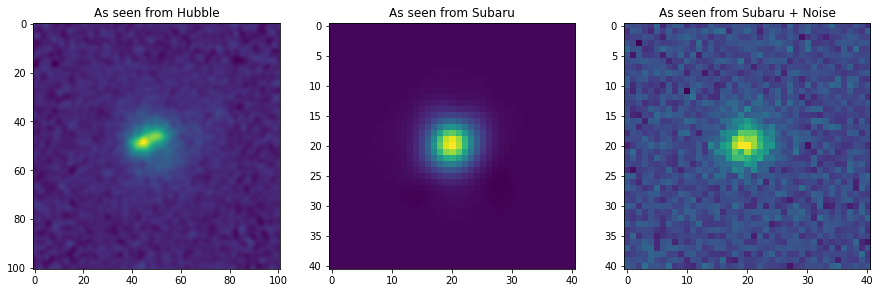

In [104]:
figure(figsize=[15,5])
subplot(131)
imshow(cosmos['image'])
title('As seen from Hubble')
subplot(132)
imshow(im)
title('As seen from Subaru')
subplot(133)
imshow(im_noise)
title('As seen from Subaru + Noise')

Or evaluate the likelihood at any given point:

In [105]:
likelihood.log_prob(im_noise)

DeviceArray(1602.9819, dtype=float32)

## Step III: Solving an inverse problem by optimization

Now that we have the ability to write a forward model and evaluate a likelihood, we can get started on trying to solve our inverse problem.

We will start by trying to recover a maximum likelihood solution 
$$ \hat{x} = \arg \max_{x} \log p(y | x) $$

Let's simulate some observations that will act as our observables $y$ and for which we will know the truth:

In [106]:
# We will use this galaxy as are reference here
x_true = cosmos['image']
y_obs = im_noise

Text(0.5, 1.0, 'Observed image')

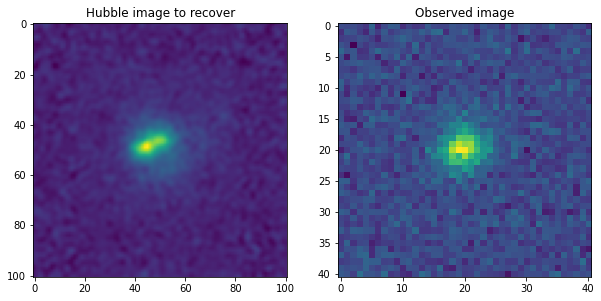

In [109]:
figure(figsize=[10,5])
subplot(121)
imshow(x_true)
title('Hubble image to recover')
subplot(122)
imshow(y_obs)
title('Observed image')

#### Writing a log likelihood function

In [45]:
def log_prob(x):
    """ Returns the value of the log likelihood of the observed data for a give x
    """
    likelihood = tfd.Independent(tfd.Normal(loc=simulate_hsc(x, cosmos['psf'], hsc['psf']),
                                            scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)

#### Creating an optimizer
Once we have a likelihood, we now want to optimize it, for this we will use the optax library:

In [46]:
import optax

optimizer = optax.adam(0.01) # Instantiate an ADAM optimizer

# Create a variable to store the solution
x = jnp.zeros([101, 101])

# Initialize the optimizer
opt_state = optimizer.init(x)

#### Writing an update function

The way optax and most JAX neural network libraries work is that the optimizer provides a function that computes how to update the parameters given the gradients of the loss function. One iteration of the optimization will look like this:

In [47]:
@jax.jit
def update(x, opt_state):
    """ Computes update to parameters x
    """
    logp, grads = jax.value_and_grad(log_prob)(x)              # Takes the gradients of the likelihood
    updates, opt_state = optimizer.update(-grads, opt_state)   # Computes ADAM update to maximize likelihood
    x = optax.apply_updates(x, updates)                        # Apply update to parameters
    return logp, x, opt_state

#### Running the optimization loop

In [48]:
losses = []

In [49]:
for i in range(200):
    logp, x, opt_state = update(x, opt_state)
    losses.append(logp)

Text(0.5, 0, 'step')

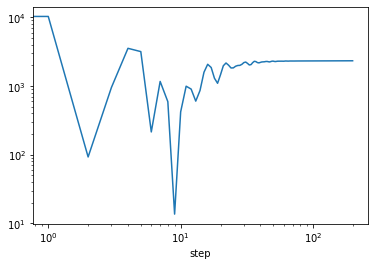

In [50]:
loglog(abs(jnp.array(losses)))
xlabel('step')

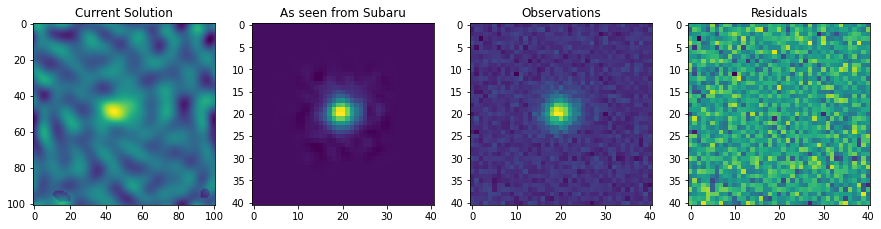

In [51]:
# Let's look at the solution!
figure(figsize=[15,5])
subplot(141)
imshow(x)
title('Current Solution')
subplot(142)
imshow(simulate_hsc(x, cosmos['psf'], hsc['psf']))
title('As seen from Subaru')
subplot(143)
imshow(y_obs)
title('Observations')
subplot(144)
imshow(y_obs - simulate_hsc(x, cosmos['psf'], hsc['psf']))
title('Residuals');

And there you have it, we have found **a** solution, which fits the observations very well! Now, is it a good solution? Given that the inverse problem is very ill-posed and that we have no prior, we get a solution that doesn't appear very physical.

###  Adding the mask and proximal regularisation 

To make things a bit more difficult, let's now consider a situation where we don't observe part of the galaxy, due to cosmic rays. Our data can be written like this:

In [52]:
x_true = cosmos['image']
cr_mask = 1.*(hsc['mask'] == 44)
y_obs = im_noise * (1 - cr_mask)

Text(0.5, 1.0, 'Cosmic Ray mask')

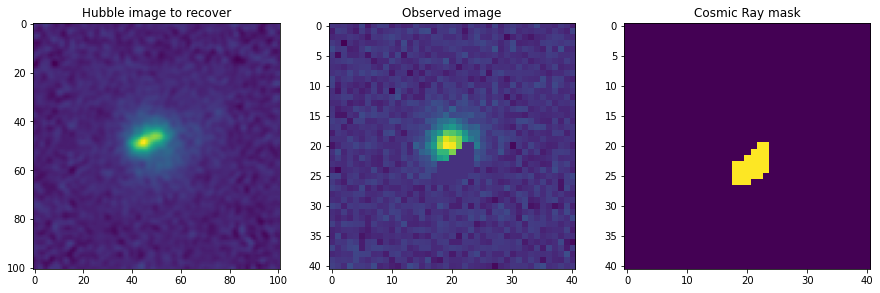

In [53]:
figure(figsize=[15,5])
subplot(131)
imshow(x_true)
title('Hubble image to recover')
subplot(132)
imshow(y_obs)
title('Observed image')
subplot(133)
imshow(cr_mask)
title('Cosmic Ray mask')

We can modify the likelihood to account for this mask, for instance by saying the regions in the mask have very high variance. This means that the value these pixels are not to be trusted.

In [67]:
def log_prob(x):
    likelihood = tfd.Independent(tfd.Normal(simulate_hsc(x, cosmos['psf'], hsc['psf']),
                                            jnp.sqrt(hsc['variance'] + cr_mask*1e3)), # We add a high noise component in mask
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)

In [68]:
optimizer = optax.adam(0.002)

# Create a parameter
x = jnp.zeros([101, 101])

opt_state = optimizer.init(x)

For fun we will add a proximal constraint in the optimization, to constrain the solution to be positive

In [69]:
@jax.jit
def update(x, opt_state):
    logp, grads = jax.value_and_grad(lambda x: log_prob(x))(x)
    updates, opt_state = optimizer.update(-grads, opt_state)
    
    # Apply gradient descent
    x = optax.apply_updates(x, updates)
    
    # Apply proximal constraints
    x = jnp.abs(x)
    
    return logp, x, opt_state

In [70]:
losses = []

In [71]:
for i in range(1000):
    logp, x, opt_state = update(x, opt_state)
    losses.append(logp)

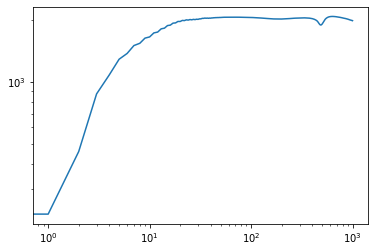

In [72]:
loglog(abs(np.array(losses)))

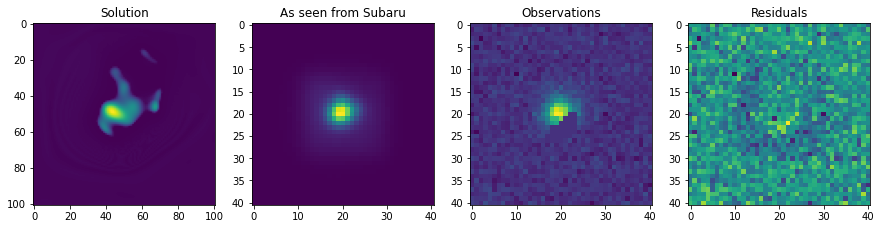

In [60]:
figure(figsize=[15,5])
subplot(141)
imshow(x)
title('Solution')
subplot(142)
imshow(simulate_hsc(x, cosmos['psf'], hsc['psf']))
title('As seen from Subaru')
subplot(143)
imshow(y_obs)
title('Observations')
subplot(144)
imshow((im_noise - simulate_hsc(x, cosmos['psf'], hsc['psf'])))
title('Residuals');

## Step IV: Naive Deep Learning  Approach

Now that we have covered the basics of how to manipulate the problem, we can try a first Deep Learning approach. Can a CNN recover the space-based image?

It should be noted that this is really not the approach we will try to follow in this data challenge, but this is a good opporrtunity to learn how to write and train a neural network in JAX.

We will use the [Haiku](https://github.com/deepmind/dm-haiku) library from DeepMind for all neural network related things.

#### Building data pipeline

Let's start with a pipeline creating examples of HST and HSC images

In [73]:
import tensorflow as tf

def preprocess(example):
    """ Augment COSMOS dataset with random flips
    """
    x = example['image'][...,tf.newaxis]
    x = tf.image.flip_left_right(x)
    x = tf.image.flip_up_down(x)
    return {'image':x[...,0], 'psf':example['psf']}

In [74]:
# Load COSMOS
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN)
dset_cosmos = dset_cosmos.cache()
dset_cosmos = dset_cosmos.repeat()
dset_cosmos = dset_cosmos.map(preprocess)
dset_cosmos = dset_cosmos.shuffle(40000)

# Load HSC
dset_hsc = tfds.load("HSC", split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.cache()
dset_hsc = dset_hsc.repeat()
dset_hsc = dset_hsc.shuffle(10000)

# Combine both datasets
combined_dset = tf.data.Dataset.zip((dset_cosmos, dset_hsc))
combined_dset = combined_dset.batch(64)                      # Adds batching
combined_dset = combined_dset.as_numpy_iterator()

In [75]:
batch = next(combined_dset)

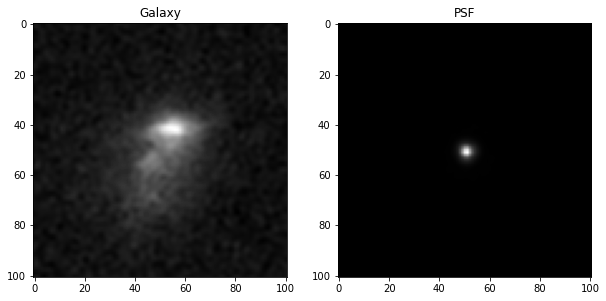

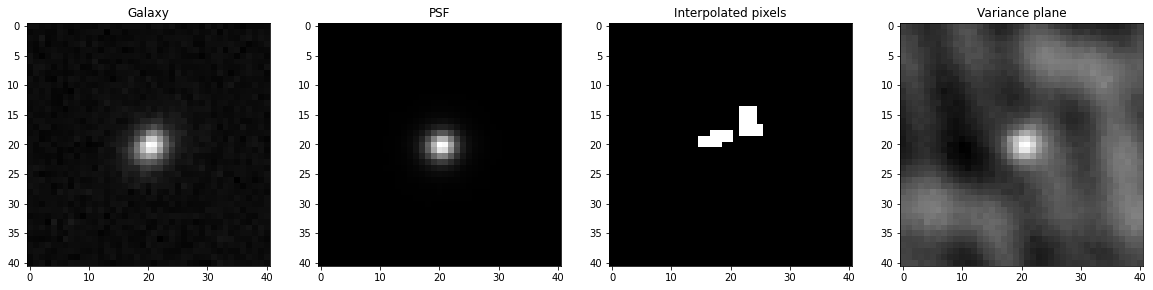

In [76]:
# A batch contains examples from both datasets
cosmos, hsc = batch

figure(figsize=[10,5])
subplot(121)
imshow(cosmos['image'][0],cmap='gray')
title('Galaxy')
subplot(122)
imshow(cosmos['psf'][0],cmap='gray')
title('PSF');

figure(figsize=[20,5])
subplot(141)
imshow(hsc['image'][0],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'][0],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'][0] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'][0],cmap='gray')
title('Variance plane');

#### Defining a Neural Network

For this kind of thing, one may think some kind of Unet might be able to solve this deconvolution task.

In Haiku, Neural Networks are defined by creating a `hk.Module` subclass and populating its `__call__` member

In [77]:
import haiku as hk

In [78]:
class Unet(hk.Module):
    """ The most trivial Unet possible
    """
    def __call__(self, x):
        x = hk.Conv2D(16, kernel_shape=3)(x)
        l1 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l1, window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(32, kernel_shape=3)(x)
        l2 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l2,  window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(64, kernel_shape=3)(x)
        l3 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l3, window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(128, kernel_shape=3)(x)
        x = jax.nn.leaky_relu(x)
        
        x = hk.Conv2DTranspose(64, kernel_shape=3, stride=2)(x)
        x = jnp.concatenate([x, l3], axis=-1)
        
        x = jax.nn.leaky_relu(x)
        x = hk.Conv2DTranspose(32, kernel_shape=3, stride=2)(x)
        x = jnp.concatenate([x, l2], axis=-1)

        x = jax.nn.leaky_relu(x)
        x = hk.Conv2DTranspose(16, kernel_shape=5, stride=2)(x)
        x = jnp.concatenate([x, l1], axis=-1)

        x = hk.Conv2D(1, kernel_shape=5)(x)
        return x

In [79]:
# Transform model into pure functions
model = hk.without_apply_rng(hk.transform(lambda x: Unet()(x)))

In [80]:
# Initialize model parameters
params = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]))

In [81]:
def loss_fn(params, rng, batch, return_images=False):
    # Create mock observations
    cosmos, hsc = batch
    
    def prep_data(cosmos, hsc):
        """ Prepares data for the neural network
        """        
        obs = tfd.Independent(tfd.Normal(jax.vmap(simulate_hsc)(cosmos['image'], cosmos['psf'], hsc['psf']),
                         jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2).sample(seed=rng)

        # Rescale obs to same pixel scale to make the life of the network easier
        x = jax.image.scale_and_translate(obs, [len(obs), 128, 128], [1,2], 
                                            jnp.array([5.6, 5.6]), 
                                            jnp.array([128/2 - 41/2*5.6 ,128/2 - 41/2*5.6 ]), 
                                            jax.image.ResizeMethod.CUBIC)

        # Resize input and outputs for the network
        im  = jnp.pad(cosmos['image'], [[0,0], [14,13] , [14,13]])

        # Adding channel dimension
        im = jnp.expand_dims(im, -1)
        x = jnp.expand_dims(x, -1)
        return im, x, obs

    im, x, obs = prep_data(cosmos, hsc )
    
    # Apply neural network
    rec = model.apply(params, x)
    
    loss = jnp.mean( jnp.sum( (rec - im)**2, axis=[1, 2, 3]))
    
    if return_images:
        return im, obs, x, rec, loss
    else:
        return loss

In [82]:
optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)
rng_seq = hk.PRNGSequence(12)
losses = []

In [83]:
@jax.jit
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    # Apply gradient descent
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [84]:
for i in range(10000):
    batch = next(combined_dset)
    loss, params, opt_state = update(params, next(rng_seq), opt_state)
    losses.append(loss)
    if i %100 ==0:
        print('step',i,loss)

step 0 1991.927
step 100 1.2297109
step 200 0.52536875
step 300 0.3452224
step 400 0.24919403
step 500 0.18768516
step 600 0.15899208
step 700 0.15189695
step 800 0.12977394
step 900 0.12751661
step 1000 0.12317885
step 1100 0.11441049
step 1200 0.11969043
step 1300 0.11283795
step 1400 0.11613483
step 1500 0.30040225
step 1600 0.10286344
step 1700 0.09646963
step 1800 0.124051176
step 1900 0.09287441
step 2000 0.09646312
step 2100 0.097823545
step 2200 0.14244062
step 2300 0.11559072
step 2400 0.24244386
step 2500 0.08975221
step 2600 0.314224
step 2700 0.13218646
step 2800 0.08572677
step 2900 0.32569522
step 3000 0.08169447
step 3100 0.17450713
step 3200 0.556446
step 3300 0.6376725
step 3400 0.10865506
step 3500 0.104567885
step 3600 2.203775
step 3700 0.11725897
step 3800 0.35200983
step 3900 0.12141571
step 4000 2.0807416
step 4100 0.07325777
step 4200 0.07558873
step 4300 0.07536008
step 4400 0.08968256
step 4500 0.07220889
step 4600 0.084937856
step 4700 0.4503972
step 4800 2.4

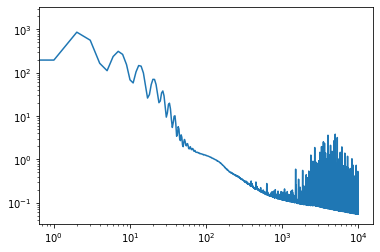

In [85]:
loglog(losses)

In [86]:
# Create a test dataset
dset_cosmos_test = tfds.load("Cosmos/23.5",
                        split=tfds.Split.TEST)
dset_cosmos_test = dset_cosmos_test.cache()
dset_cosmos_test = dset_cosmos_test.repeat()

dset_hsc = tfds.load("HSC",
                     split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.cache()
dset_hsc = dset_hsc.repeat()
dset_hsc = dset_hsc.shuffle(10000)

combined_dset_test = dset_hsc.zip((dset_cosmos_test , dset_hsc))
combined_dset_test = combined_dset_test.batch(64)

In [87]:
it_test  = combined_dset_test.as_numpy_iterator()

In [88]:
batch = next(it_test)
im, obs, y, rec, loss = loss_fn(params, next(rng_seq), batch, return_images=True)
cosmos, hsc = batch

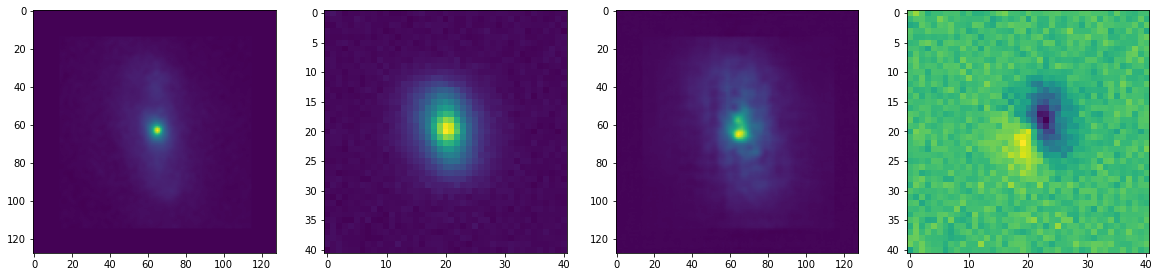

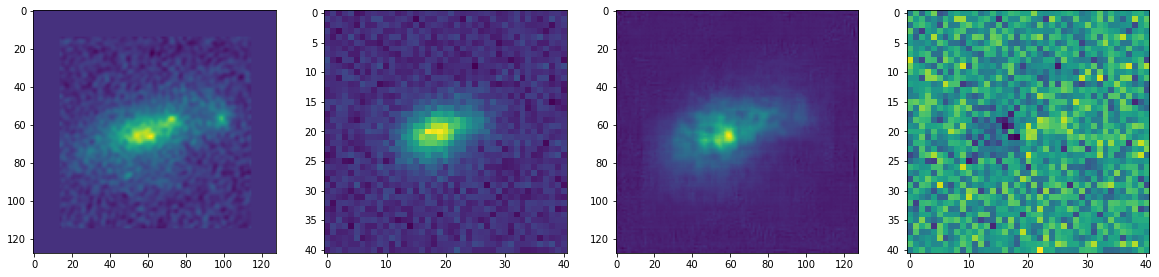

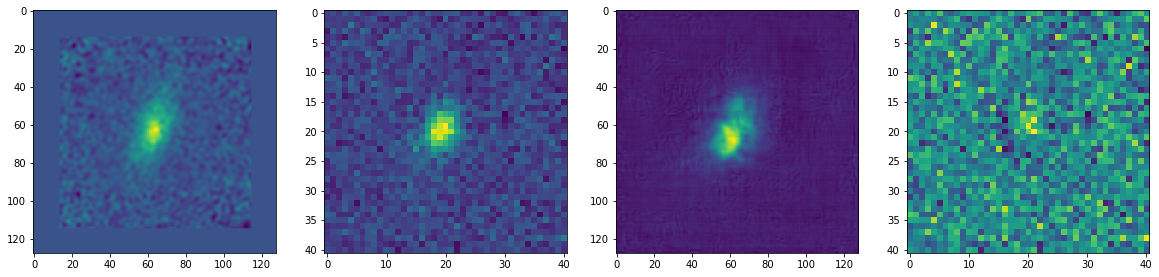

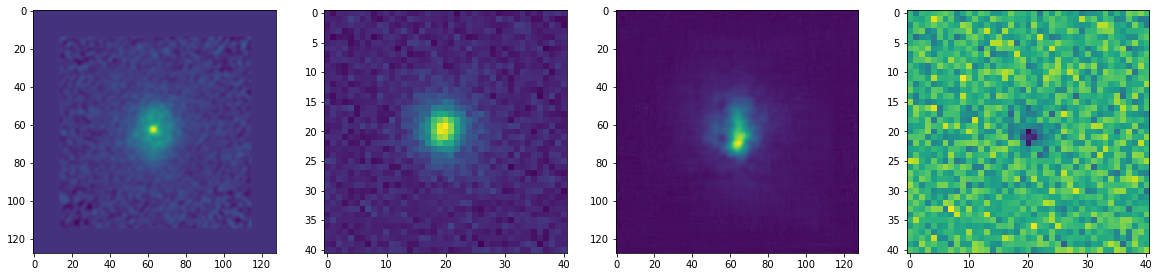

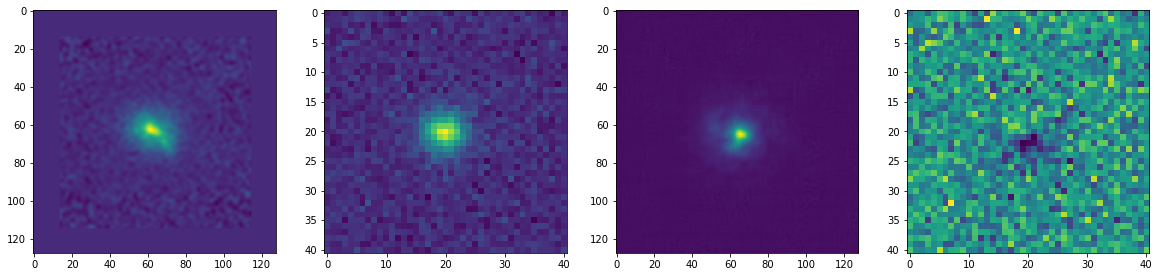

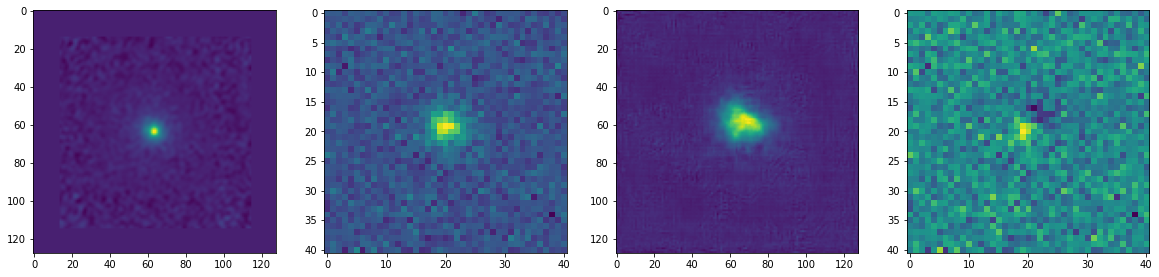

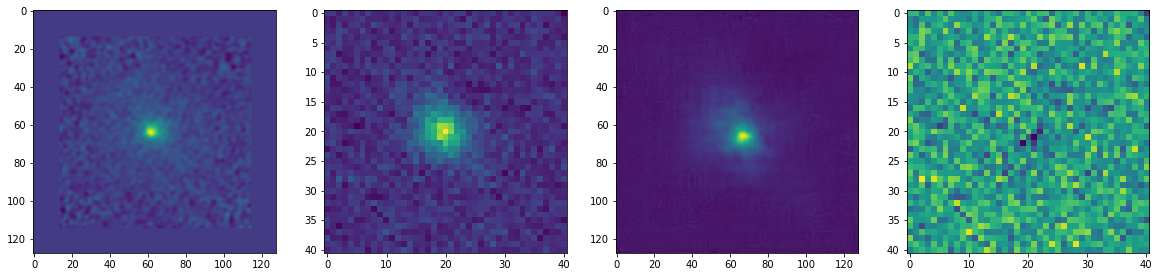

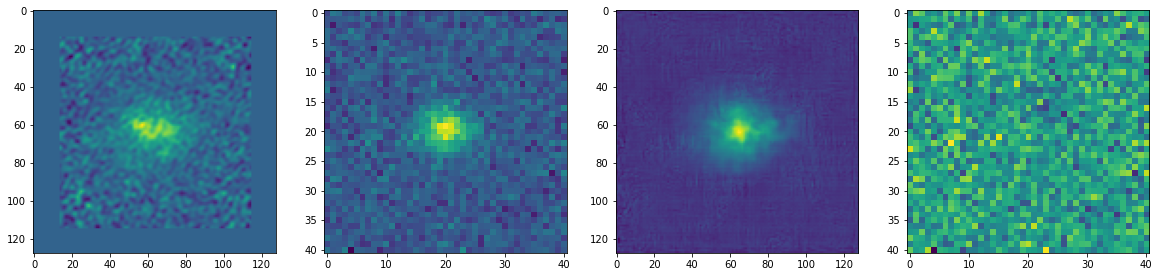

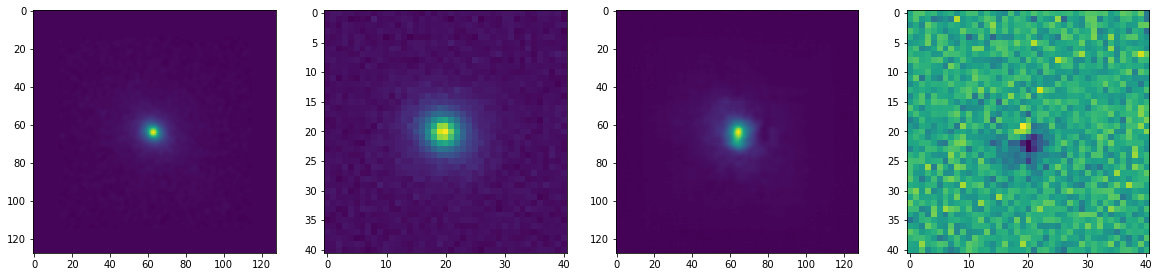

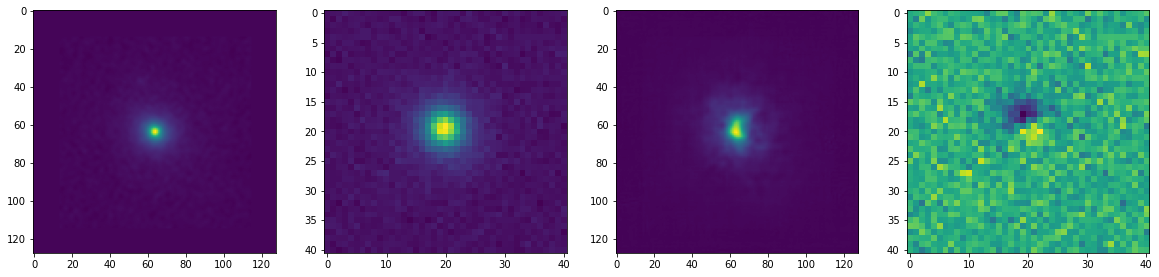

In [89]:
for i in range(10):
    figure(figsize=[20,5])
    subplot(141)
    imshow(im[i])
    subplot(142)
    imshow(obs[i])
    subplot(143)
    imshow(rec[i])
    subplot(144)
    # Removing the padding
    x = rec[i][14:-13:,14:-13:,0]
    x = simulate_hsc(x, cosmos['psf'][i], hsc['psf'][i])
    # Show residuals on observations
    imshow(obs[i] - x)